In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely.wkt
import utilities
from calitp import *
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Load in Provider Maps
* These maps contain areas that *do not* have data coverage by providers. 

In [2]:
verizon = gpd.read_parquet(
"gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_all_counties.parquet")

In [3]:
verizon.geometry.is_valid.all()

True

In [4]:
att = gpd.read_parquet(
"gs://calitp-analytics-data/data-analyses/cellular_coverage/att_all_counties.parquet")

In [5]:
# Make a copy of ATT for testing
att2 = att.copy()

In [6]:
# simplify the geometry
att2["geometry"] = att2.geometry.simplify(tolerance=25)

In [7]:
att2.shape

(3, 1)

<AxesSubplot:>

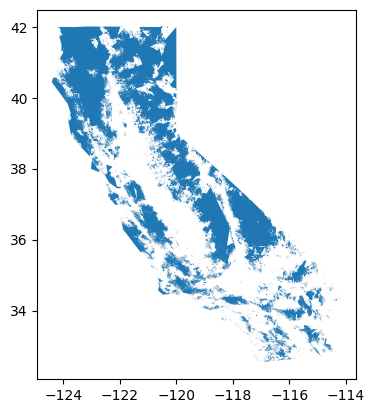

In [8]:
att2.plot()

### Load in Routes 

In [9]:
unique_routes = utilities.load_unique_routes_df()

In [10]:
unique_routes.geometry.is_valid.all()

True

In [11]:
# Ensure CRS are the same
unique_routes = unique_routes.to_crs(att2.crs)

In [12]:
unique_routes.crs == att2.crs 

True

In [13]:
# B/c route names and route ids can be the same across different agencies,
# Add these 3 different columns so the route will have a unique identifier.
# Just in case I want to loop through everything
unique_routes['long_route_name'] = unique_routes['route_name'] + unique_routes['route_id'] + ' '  + ' ' + unique_routes['agency']

In [14]:
unique_routes.long_route_name.nunique() == len(unique_routes) 

True

#### Splitting the df 

In [15]:
# Split this large dataframe into 5
# https://stackoverflow.com/questions/17315737/split-a-large-pandas-dataframe
df_split = np.array_split(unique_routes, 5)

In [16]:
# Grab split out df for testing 
unique_routes1 = df_split[0]
unique_routes2 = df_split[1]
unique_routes3 = df_split[2]
unique_routes4 = df_split[3]
unique_routes5 = df_split[4]

In [17]:
# Checks
unique_routes1.crs == att2.crs, len(unique_routes1), type(unique_routes1)

(True, 566, geopandas.geodataframe.GeoDataFrame)

#### Testing with certain routes - Help
* Routes that gave me issues the first time around
* Getting an error when using the `att2` gdf which simplifies geometry.
    * `TopologyException: Input geom 1 is invalid: Hole lies outside shell at -124.1036 40.437482000000003`
    *  Works fine with original att df?

In [18]:
# Routes from analysis v1 that didn't make sense
routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Long Beach/San Pedro"
]

In [19]:
unique_routes_subset = unique_routes[unique_routes["route_name"].isin(routes_wanted)]

In [20]:
len(unique_routes_subset)

22

In [21]:
unique_routes_subset.geometry.is_valid.all()

True

In [22]:
unique_routes_subset.crs == att2.crs

True

In [23]:
# Testing with original AT&T dataframe without simplifying geometry
intersect_subset1 = gpd.overlay(unique_routes_subset, att, how="intersection")

In [24]:
intersect_subset1

,itp_id,route_id,route_name,agency,original_route_length,long_route_name,geometry
0,127,705-240,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation ...,56918.543438,Oakland - San Francisco705-240 Golden Gate Br...,"MULTILINESTRING ((-122.32825 37.82216, -122.32..."
1,183,870,Long Beach/San Pedro,Los Angeles Department of Transportation,45275.955178,Long Beach/San Pedro870 Los Angeles Departmen...,"LINESTRING (-118.22198 33.76428, -118.22279 33..."
2,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.128572,Mammoth Lakes HWY 120E/395582 Yosemite Area R...,"MULTILINESTRING ((-119.62221 37.72721, -119.62..."


In [25]:
# Doesn't work with geometry simplify?
intersect_subset2 = gpd.overlay(unique_routes_subset, att2, how="intersection")

GEOSException: TopologyException: Input geom 1 is invalid: Hole lies outside shell at -124.1036 40.437482000000003

#### Test in a loop

In [26]:
# Grab unique long route names for entire routes_df into a list
unique_routes_names_entire_list = unique_routes5.long_route_name.unique().tolist()

In [27]:
len(unique_routes_names_entire_list)

2829

In [28]:
unique_routes_names_entire_list[1]

'MLK Jr. - Temescal - Grand12  AC Transit'

In [29]:
len(unique_routes)

2829

In [30]:
unique_routes[unique_routes.long_route_name == 'MLK Jr. - Temescal - Grand12  AC Transit']

,itp_id,route_id,geometry,route_name,agency,original_route_length,long_route_name
1,4,12,"LINESTRING (-122.30044 37.87949, -122.30023 37...",MLK Jr. - Temescal - Grand,AC Transit,59650.288546,MLK Jr. - Temescal - Grand12 AC Transit


In [31]:
# Empty dataframe to hold each district after clipping
all_intersected_routes = pd.DataFrame()

In [ ]:
# Test with subsetted unique routes
for i in unique_routes_names_entire_list:
    unique_routes_filtered  = unique_routes[unique_routes.long_route_name == i].reset_index(
            drop=True
    )

    # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
    intersected = gpd.overlay(unique_routes_filtered, att2, how="intersection")
    all_intersected_routes = pd.concat([all_intersected_routes, intersected], axis=0)
    print(f"Done intersecting & concatting for {i}")

Done intersecting & concatting for E. 14th St. - Mission10  AC Transit
Done intersecting & concatting for MLK Jr. - Temescal - Grand12  AC Transit
Done intersecting & concatting for 14th St - San Antonio - High St14  AC Transit
Done intersecting & concatting for Solano - Shattuck - MLK Jr.18  AC Transit
Done intersecting & concatting for Buena Vista - Fruitvale19  AC Transit
Done intersecting & concatting for Uptown Oakland\ San Leandro BART Southbound OWL1t  AC Transit
Done intersecting & concatting for Dimond - Fruitvale - South Shore20  AC Transit
Done intersecting & concatting for Decoto - Newark Blvd. - Mowry200  AC Transit
Done intersecting & concatting for Dimond - Fruitvale - Bay Farm21  AC Transit
Done intersecting & concatting for Fremont Blvd. - Mission San Jose210  AC Transit
Done intersecting & concatting for Fremont Blvd. - Pacific Commons212  AC Transit
Done intersecting & concatting for Osgood - Warm Springs - Landing215  AC Transit
Done intersecting & concatting for Ni

In [ ]:
intersected_routes.shape

In [ ]:
intersected_routes

In [ ]:
# Test with complete unique routes gdf
"""
for i in unique_routes_names_list:
    unique_routes  = unique_routes[unique_routes.long_route_name == i].reset_index(
            drop=True
    )

    # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
    intersect = gpd.overlay(unique_routes, att2, how="intersection")
    intersected_routes = pd.concat([intersected_routes, intersect], axis=0)
    print(f"Done intersecting & concatting for {i}") """